In [2]:
import time
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx

import pandas as pd
import random as rnd
import scipy.sparse as sparse
import random
import implicit 
import datetime

data_path = '../one100K_v2.json'

#### Simply we load the data from our scrapped tweets file: one100K_v2.json to a list tweets

In [3]:
## LOAD OUR DATA FROM THE SCRAPPED TWEETS
docs_path = data_path
with open(docs_path) as fp:
    lines = fp.readlines()
tweets = [l.strip().replace(' +', ' ') for l in lines]

In [4]:
print("Total numer of tweets in the corpus: {}" .format(len(tweets)))

Total numer of tweets in the corpus: 100001


#### Create a dictionary for each tweet
For each tweet, creates a dictionary containing the most relevant information of it (Username, OriginalText, Clean Tokens, number of Likes, number of retweets, list of URLs...)
    
    Argument:  tweet -- a JSON tweet content    
    Returns:   dictRelevantInfo -- a dictionary with the processed tweet

In [5]:
def getRelevantInfo(tweet):
    dictRelevantInfo ={}
    data = json.loads(tweet)
    hashtags = []
    urlsList = []
    text = ''
    date = data['created_at'] 
    
    ## TRY TO OBTAIN INFORMATION ABOUT THE RETWEETED TWEET IF 'tweet' IS A RT.
    try:
        isRt=True
        isRetweet=data["retweeted_status"]
        idTweet=data["id_str"]
        text = isRetweet['text']
        usernamert=isRetweet['user']['screen_name']
        username = data['user']['screen_name']
        urls = isRetweet['entities']['urls']
        rt_count = isRetweet['retweet_count']
        likes = isRetweet['favorite_count']
        id_retweet=isRetweet["id_str"]
        for h in isRetweet['entities']['hashtags']:
            hashtags.append(h['text'])
        for url in urls:
            urlsList.append(url['url'])
            
    ## IF THE CURRENT TWEET IS NOT A RT WE OBTAIN INFORMATION ABOUT THE ORIGINAL.
    except:
        isRt=False
        idTweet=data["id_str"]
        text = data['text']
        username = data['user']['screen_name']
        urls = data['entities']['urls']
        rt_count=data['retweet_count']
        likes = data['favorite_count']
        id_retweet=None
        usernamert=None
        for h in data['entities']['hashtags']:
            hashtags.append(h['text'])
            
        for url in urls:
            urlsList.append(url['url'])        
            
    dictRelevantInfo['tweetID'] = idTweet
    dictRelevantInfo['text'] = text
    dictRelevantInfo['username'] = username
    dictRelevantInfo['date'] = date
    dictRelevantInfo['hashtags'] = hashtags
    dictRelevantInfo['likes'] = likes
    dictRelevantInfo['rt_count'] = rt_count
    dictRelevantInfo['urlsList'] = urlsList
    dictRelevantInfo['isRetweeted'] = isRt
    dictRelevantInfo['idRt'] = id_retweet
    dictRelevantInfo['usernameRT'] = usernamert
    return dictRelevantInfo

In [6]:
cleanTweets = {}
for t in tweets:
    currentTweet=getRelevantInfo(t)
    tweetID=currentTweet['tweetID']
    cleanTweets[tweetID] = currentTweet

In [7]:
print(len(cleanTweets))

100000


#### Generate a graph from the interactions of users that Retweets.
We ignore all the tweets owner that are original, because not has interaction with other tweets, and later appear in the graph if other users retweet its tweets.
    
    Argument:  cleanTweets -- dictionary of dictionaries with all relevant info for each tweet
    Returns:   g -- a directed graph with edges between User 1 --> User 2 (where user1 retweet user2).

In [8]:
def getRtGraph(cleanTweets):
    freqRT={}
    g=nx.DiGraph()
    for t in cleanTweets:
        ## ONLY GENERATES A GRAPH WITH THE INTERACTIONS ON THE RETWEETS. IF THE CURRENT TWEET IS NOT A RT,
        ## WE IGNORE IT
        if cleanTweets[t]['isRetweeted']==True and cleanTweets[t]["idRt"] in cleanTweets:
            key=str(hash(cleanTweets[t]["username"]))+"->"+str(hash(cleanTweets[t]["usernameRT"]))
            if key in freqRT:
                freqRT[key] += 0.5
            else:
                freqRT[key] = 0.1
            # GENERATE EDGES (AND NODES, add_edge() ADDS NODES IF NOT EXIST), FROM THE RT USER TO ORIGINAL USER.
            g.add_edge(hash(cleanTweets[t]["username"]),hash(cleanTweets[t]["usernameRT"]),weight=freqRT[key])
    return g, freqRT

In [9]:
graph, freqRT=getRtGraph(cleanTweets)

## WEIGHT EDGES
weighted_edges=[]
width=[]
for (u,v,data) in graph.edges(data=True):
    weighted_edges.append((u,v))
    width.append(data['weight'])

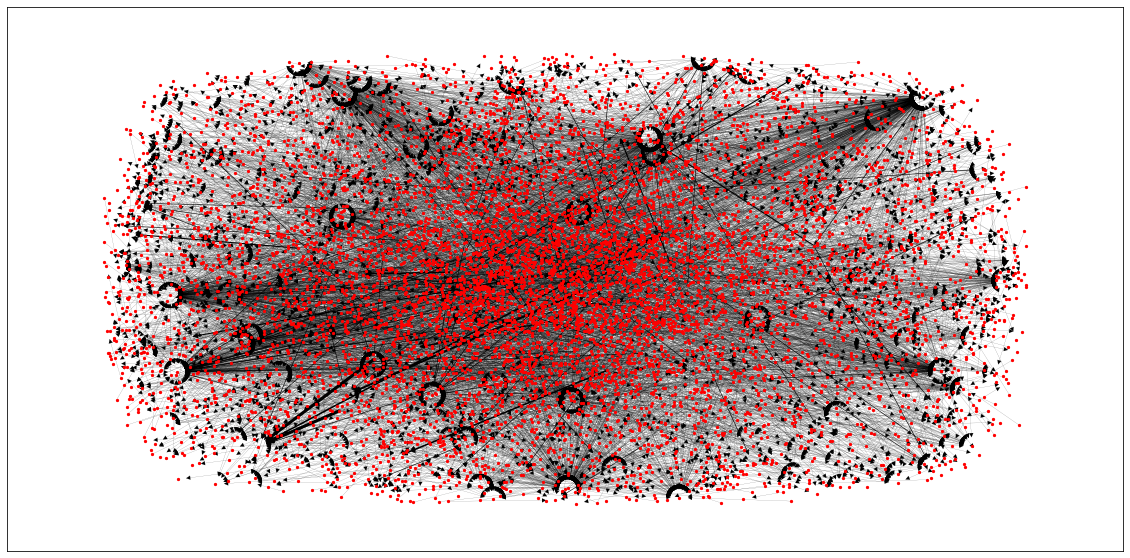

In [11]:
plt.figure(figsize=(20,10))
pos=nx.spring_layout(graph, iterations=5)
nx.draw_networkx_nodes(graph, pos, node_size=5, node_color='red') 
_=nx.draw_networkx_edges(graph,pos,edgelist=weighted_edges,width=width)
plt.show()

In [12]:
print(graph.number_of_nodes())

8554


In [13]:
edges_shuffle=list(nx.to_edgelist(graph))

In [14]:

rnd.shuffle(edges_shuffle)

train=edges_shuffle[:int(len(edges_shuffle)*0.8)]
test=edges_shuffle[int(len(edges_shuffle)*0.8):]

In [15]:
print(len(edges_shuffle))
print(len(test))
print(len(train))

8845
1769
7076


In [16]:
#### PAGE RANK
pagerank = nx.pagerank(graph)

pagerank_sorted=dict(sorted(pagerank.items(), key=lambda item: item[1] , reverse=True))
for x in pagerank_sorted:
    print(x)
    print(pagerank_sorted[x])
    print()


-533634939701600038
0.0407675949897253

5695491543410207641
0.030946222159959187

8423749741183383911
0.019103129041903852

8987791794411118619
0.018892080920100637

-8039243576150677907
0.014173303891428601

5150233397546840158
0.013950838900997208

4759651577357456778
0.01039217242489423

5691360144038989865
0.009796458610769157

4614455353894323367
0.009308447649358197

1383830909004350930
0.008911939211213867

656979629031674066
0.006691256574912095

5774704737216012823
0.006102586251958607

9013420184144760012
0.005703460195308964

-8403205369275209010
0.0051092365735994506

3819056154990543306
0.004778941132458523

-2244408008558970467
0.004751131416709467

-6307681017672954378
0.0046580721016078195

-8979501614849342503
0.004620545651465954

7692161972093734342
0.004171120050381013

3932848366614129297
0.0038730692552442357

48953092559786658
0.0038487695281757927

618120709996790815
0.003758607731771601

8196241423405578330
0.003728534838682538

-2267778920988661110
0.003568468

-4764098148644021104
5.947874932118452e-05

-4085700471630203031
5.947874932118452e-05

2661580849582667754
5.947874932118452e-05

6735317776791890832
5.947874932118452e-05

-718845095006287126
5.947874932118452e-05

-1401491930239978453
5.947874932118452e-05

-1919326191537047154
5.947874932118452e-05

-4317311614477790836
5.947874932118452e-05

7004253388779687987
5.947874932118452e-05

-2499266989906226368
5.947874932118452e-05

4570617918303952306
5.947874932118452e-05

-998288259584266156
5.947874932118452e-05

-3047770950516508992
5.947874932118452e-05

-1004699303230672113
5.947874932118452e-05

-1472742831541365558
5.947874932118452e-05

-7396062653441907074
5.947874932118452e-05

-6340802401513371684
5.947874932118452e-05

-3156046101622189376
5.947874932118452e-05

-6885523139704134540
5.947874932118452e-05

-3856836088188363116
5.947874932118452e-05

-7268592414268459455
5.947874932118452e-05

-6656081720739673581
5.947874932118452e-05

-3588670438005439465
5.947874932118452

-1682866884085532872
5.947874932118452e-05

-834597638385426177
5.947874932118452e-05

5336570954393675098
5.947874932118452e-05

551188118695543218
5.947874932118452e-05

7937868596424605643
5.947874932118452e-05

86981270638850177
5.947874932118452e-05

4614645449465848007
5.947874932118452e-05

-3171004250923686320
5.947874932118452e-05

6989482327753209846
5.947874932118452e-05

7485831919694934152
5.947874932118452e-05

8449035930108299839
5.947874932118452e-05

-292859476751387766
5.947874932118452e-05

-3091005322153987820
5.947874932118452e-05

6599325523947008055
5.947874932118452e-05

2644413041978464222
5.947874932118452e-05

-1445531258961159650
5.947874932118452e-05

4460873543266654860
5.947874932118452e-05

-2421607454894447129
5.947874932118452e-05

-7465290976661910288
5.947874932118452e-05

-6817097070026351303
5.947874932118452e-05

1118269134831758541
5.947874932118452e-05

-7556112793563474481
5.947874932118452e-05

1103582683337968410
5.947874932118452e-05

723584


-7086286112098169163
5.947874932118452e-05

-243082018039602985
5.947874932118452e-05

9176878540733203307
5.947874932118452e-05

-6724149208273066287
5.947874932118452e-05

-3781286141908301155
5.947874932118452e-05

7123772934610837669
5.947874932118452e-05

-6097387788310139618
5.947874932118452e-05

-4313620461780730031
5.947874932118452e-05

-766498863895237172
5.947874932118452e-05

3827420764966669958
5.947874932118452e-05

-4322533167194067404
5.947874932118452e-05

-8287541123059166057
5.947874932118452e-05

3686092250205144681
5.947874932118452e-05

7941541348724936070
5.947874932118452e-05

-1440293158436788886
5.947874932118452e-05

-2854568593803031627
5.947874932118452e-05

3272681706678758753
5.947874932118452e-05

-7035581307046023417
5.947874932118452e-05

-845606278791893508
5.947874932118452e-05

4747090858543568306
5.947874932118452e-05

-351476589631274889
5.947874932118452e-05

8995047626117692885
5.947874932118452e-05

2472433397574835535
5.947874932118452e-05



5.947874932118452e-05

2332741610484468203
5.947874932118452e-05

8745965335716960513
5.947874932118452e-05

8202138447618522053
5.947874932118452e-05

-6716940337459821202
5.947874932118452e-05

3920797173604328340
5.947874932118452e-05

5852821689852338702
5.947874932118452e-05

5514579984016557696
5.947874932118452e-05

-1930814054443596298
5.947874932118452e-05

7104700130405896506
5.947874932118452e-05

-4013254795158030638
5.947874932118452e-05

-4723413278476015379
5.947874932118452e-05

-8672584846127718087
5.947874932118452e-05

-2281475931075039889
5.947874932118452e-05

7787926735103561003
5.947874932118452e-05

-1025988466005544631
5.947874932118452e-05

-5226970301156187764
5.947874932118452e-05

-4134958693740544043
5.947874932118452e-05

5228370452264402638
5.947874932118452e-05

-8674981131662214654
5.947874932118452e-05

-9146189573511534197
5.947874932118452e-05

4644970999709675730
5.947874932118452e-05

1373721894900389643
5.947874932118452e-05

6607583779370253967


In [17]:
undirected_graph=graph.to_undirected(reciprocal=False, as_view=False)

In [16]:
ebunch=[]
for edg in undirected_graph.nodes():
    for edg2 in undirected_graph.nodes():
        if edg!=edg2:
            ebunch.append((edg,edg2))

In [21]:
prediction=nx.adamic_adar_index(undirected_graph,ebunch)

In [22]:
#pr2=dict(sorted(prediction.items(), key=lambda item: item[2] , reverse=True))
print(prediction)
for v in prediction:
    if v[2]!=0:
        print(v)
    

NameError: name 'test2' is not defined

In [10]:
arr_users=[]

for x in graph:
    arr_users.append(str(x))

df = pd.DataFrame(index=arr_users, columns=arr_users)

In [11]:
for t in freqRT:
    tArr=t.split("->")
    usuariQueRT=tArr[0]
    usuariRTejat=tArr[1]
    df.at[usuariQueRT,usuariRTejat] = freqRT[t]

In [12]:
df=df.fillna(0)
display(df)

,-8293560887546710009,4933023119167420507,-7509422096918454521,-8951135097793909860,-4798262637242519238,1624031144759685516,-5467267926325819344,-6305029250319235222,5070518676159270356,-3709917915835072082,...,-3647296801488076696,-8833399421983984193,3601504718338551093,6303076204801797527,-6313725219292013444,7487570973196012565,5206276237831102371,2073923658483897139,7638956619163970285,745671525455552192
-8293560887546710009,0,0.1,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
4933023119167420507,0,0.0,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
-7509422096918454521,0,0.0,0,0.1,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
-8951135097793909860,0,0.0,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
-4798262637242519238,0,0.0,0,0.0,0,0.1,0,0.1,0,0,...,0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487570973196012565,0,0.0,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
5206276237831102371,0,0.0,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
2073923658483897139,0,0.0,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
7638956619163970285,0,0.0,0,0.0,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0


In [ ]:

a,b,c= np.linalg.svd(df)